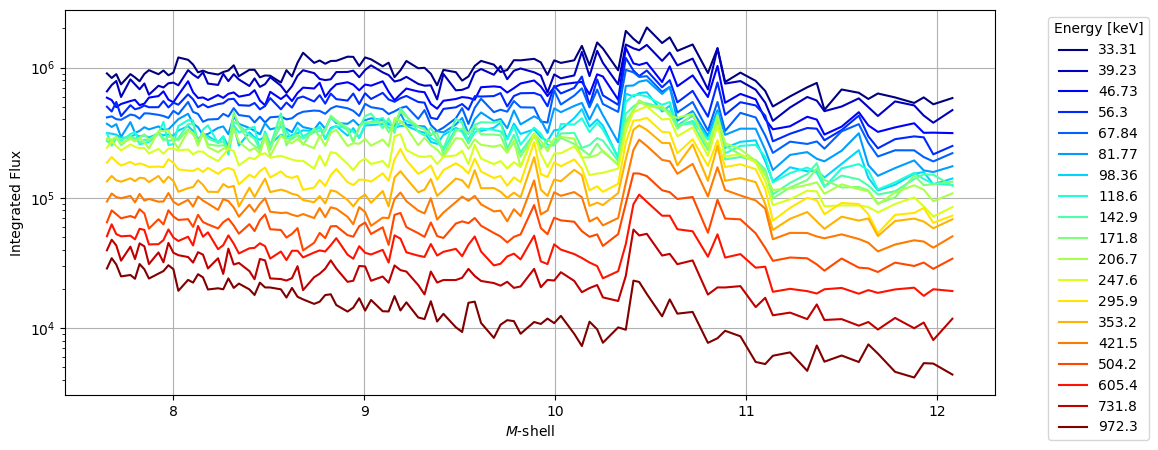

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def safe_convert_to_float(value): #converts string to float. (ex: 1.2e3 --> 1200)
    try:
        return float(value)
    except ValueError:
        base, _, exponent = value.partition('e')
        exponent = exponent.replace('.1', '')
        return float(f"{base}e{exponent}")
    
data_corrected_spin = pd.read_csv("Formatted_Dataset.csv",delimiter=',')
grouped_data_spin = data_corrected_spin.groupby(['Mshell', 'Energy'])['Flux'].mean().reset_index()
pivot_table_spin = grouped_data_spin.pivot("Energy", "Mshell", "Flux")

'''Align with corrected spin-averaged high resolution electron data (due to penetration)'''

data_hi = pd.read_csv('flux_pad_JADE_JEDI_jan_late_hires.txt', delim_whitespace=True) #high resolution electron data
grouped_data = data_hi.groupby(['Mshell', 'energy'])['flux'].mean().reset_index()
data_hi_filter = grouped_data[((grouped_data['energy'])>30)] #for JEDI data, only keep energy channels above 30 keV

Mshell = data_hi['Mshell']
u_m = np.unique(Mshell)
u_m_cor = np.unique(data_corrected_spin['Mshell'])

# Find the indices of the closest values in u_m_corr for each value in u_m
nearest_indices = np.abs(u_m_cor[:, np.newaxis] - u_m).argmin(axis=0)
u_m_cor_near = u_m_cor[nearest_indices]

Total_ratio = []
Total_Mshell = []
Total_energy = [] 
for k in np.arange(0,len(u_m),1):
    data_hi_m_test = data_hi_filter[(data_hi_filter['Mshell'])==u_m[k]]
    data_corrected_spin_test = data_corrected_spin[(data_corrected_spin['Mshell'])==u_m_cor_near[k]]

    data_energy_hi = np.array(data_hi_m_test['energy'])
    data_flux_hi = np.array(data_hi_m_test['flux'])
    data_corrected_spin_flux = np.array(data_corrected_spin_test['Flux'])
    ratio_fix = []
    data_flux_hi_fix = []
    for i in np.arange(0,len(data_flux_hi),1):
        if data_flux_hi[i]>=1.2*data_corrected_spin_flux[i] and data_energy_hi[i]>80:
            ratio_fix.append(data_flux_hi[i]/data_corrected_spin_flux[i])
            data_flux_hi_fix.append(data_corrected_spin_flux[i])
        else:
            data_flux_hi_fix.append(data_flux_hi[i])
            ratio_fix.append(1)
    Total_ratio.append(ratio_fix)
    Total_Mshell.append(list(data_hi_m_test['Mshell']))
    Total_energy.append(list(data_hi_m_test['energy']))

'''
Total_ratio is a variable that tells us the change between the observed and corrected values at 
every energy. Now find the M-shell and energy that this applies to, regardless
of pitch angle, and divide the flux by this value
'''
data_hi_corrected = data_hi.copy()
data_hi_corrected["flux"] = pd.to_numeric(data_hi_corrected["flux"], errors="coerce")

# Apply the corrections again
for i in range(len(Total_ratio)):  # Iterate through each set of corrections
    for j in range(len(Total_ratio[i])):  # Iterate through each energy-Mshell pair
        mshell_value = Total_Mshell[i][j]
        energy_value = Total_energy[i][j]
        ratio = Total_ratio[i][j]

        if ratio != 1:  # Only apply correction where needed
            mask = (data_hi_corrected["Mshell"] == mshell_value) & (data_hi_corrected["energy"] == energy_value)
            data_hi_corrected.loc[mask, "flux"] /= ratio

'''Integrate the flux below the southern loss cone to get the precipitation '''
loss_cone_data = pd.read_csv('loss_cone.txt', delim_whitespace=True)
data_hi_corrected['Time'] = pd.to_datetime(data_hi_corrected['Time'])
loss_cone_data['Time'] = pd.to_datetime(loss_cone_data['Time'])

data_hi_corrected['loss_s_angle'] = np.nan

for index, row in data_hi_corrected.iterrows():
    closest_time = loss_cone_data.iloc[(loss_cone_data['Time'] - row['Time']).abs().argsort()[:1]] #get nearest positions between 2 datasets
    data_hi_corrected.at[index, 'loss_s_angle'] = closest_time['loss_s'].values[0]

data_above_30 = data_hi_corrected[((data_hi_corrected['energy'] > 30))]  

# Create an empty DataFrame to hold integrated precipitation data by energy
integrated_precipitation_by_energy = pd.DataFrame()

for energy in sorted(data_above_30['energy'].unique()):
    data_filtered_energy = data_above_30[data_above_30['energy'] == energy]
    data_filtered_energy = data_filtered_energy[data_filtered_energy['pitch_angle'] <= data_filtered_energy['loss_s_angle']]
    data_filtered_energy = data_filtered_energy.dropna(subset=['flux'])
    pitch_angle_counts = data_filtered_energy.groupby('Mshell')['pitch_angle'].count()
    valid_mshells = pitch_angle_counts[pitch_angle_counts > 1].index
    data_filtered_energy = data_filtered_energy[data_filtered_energy['Mshell'].isin(valid_mshells)]
    integrated_precipitation = data_filtered_energy.groupby('Mshell')['flux'].sum().reset_index()
    integrated_precipitation.rename(columns={'flux': f'{energy}'}, inplace=True)
    if integrated_precipitation_by_energy.empty:
        integrated_precipitation_by_energy = integrated_precipitation
    else:
        integrated_precipitation_by_energy = pd.merge(integrated_precipitation_by_energy, integrated_precipitation, on='Mshell', how='outer')

fig, ax = plt.subplots(figsize=(12, 5))
color_map = plt.get_cmap('jet')
colors = color_map(np.linspace(0, 1, len(integrated_precipitation_by_energy.columns) - 1))

for i, column in enumerate(integrated_precipitation_by_energy.columns[1:]):  # Skip the first column ('Mshell')
    ax.plot(integrated_precipitation_by_energy['Mshell'], integrated_precipitation_by_energy[column], color=colors[i], label=column)

ax.set_xlabel('$M$-shell')
ax.set_ylabel('Integrated Flux')
ax.legend(title='Energy [keV]', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_yscale('log')
plt.show()

07-May-25 11:39:42: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
07-May-25 11:39:42: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


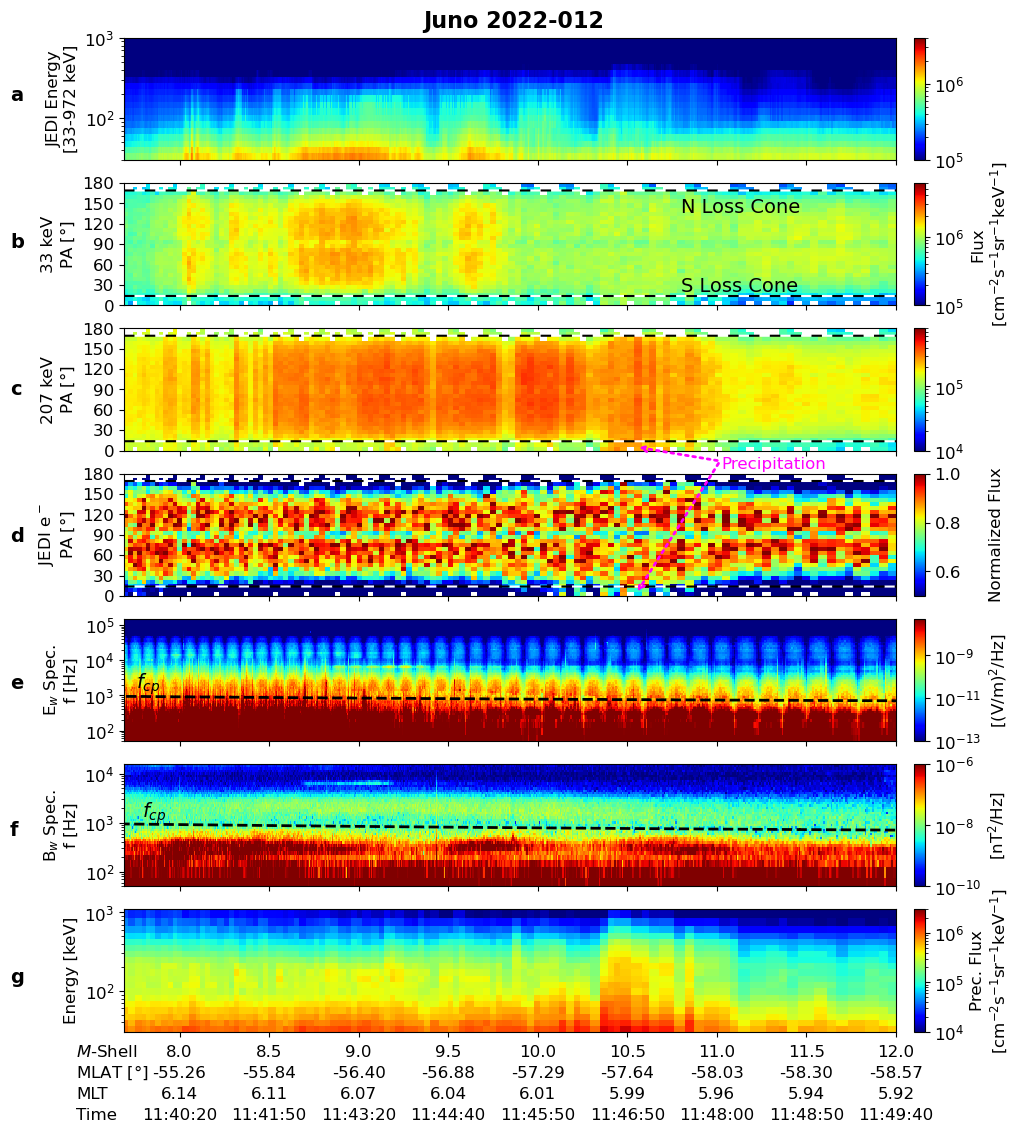

In [12]:
'''This code produces Figure 2'''

import scipy.integrate
# Calculate I_E (numerator) and I_N (denominator) from equation 2
I_E_values = []
I_N_values = []

Mshell = integrated_precipitation_by_energy['Mshell'].values
energy_levels = [float(col) for col in integrated_precipitation_by_energy.columns[1:]]

flux = integrated_precipitation_by_energy.iloc[:, 1:].values.T  # Transpose to match dimensions
for i in range(len(flux[0])):
    I_E = scipy.integrate.simps(flux[:, i] * energy_levels, energy_levels) * np.pi * 1.602e-9
    I_N = scipy.integrate.simps(flux[:, i], energy_levels)
    I_E_values.append(I_E)
    I_N_values.append(I_N)

#setup data for plot
data_loss = loss_cone_data
frequency_test_path = '011222frequency_jan_late.txt' #import Electric wave data
frequency_test_df = pd.read_csv(frequency_test_path, header=0, sep="\s+", engine='python')
frequency_hz = np.array([safe_convert_to_float(f) for f in frequency_test_df.columns[3:]])
# Use Mshell as x-axis values
mshell_values = frequency_test_df['Mshell'].values
T, F = np.meshgrid(mshell_values, frequency_hz)
electric_spectral_density = frequency_test_df.iloc[:, 3:].values
electric_spectral_density = electric_spectral_density.T
# Read the frequency test data
frequency_test_path_bw = '011222frequency_jan_bw_late.txt' #import Magnetic wave data
frequency_test_df_bw = pd.read_csv(frequency_test_path_bw, header=0, sep="\s+", engine='python')
frequency_hz_bw = np.array([safe_convert_to_float(f) for f in frequency_test_df_bw.columns[3:]])
# Use Mshell as x-axis values
mshell_values_bw = frequency_test_df_bw['MShell'].values
T_bw, F_bw = np.meshgrid(mshell_values_bw, frequency_hz_bw)
magnetic_spectral_density = frequency_test_df_bw.iloc[:, 3:].values
magnetic_spectral_density = magnetic_spectral_density.T


gen_loc_data = pd.read_csv('gen_location_late.txt',delim_whitespace=True) #location of spacecraft
Time_loc = gen_loc_data['Time']
Mshell_loc = gen_loc_data['Mshell']
MLAT_loc = gen_loc_data['MagLat'] 
MLT_loc = gen_loc_data['MLT']
R_loc = gen_loc_data['R']


energy_levels = np.array(energy_levels)
energy_levels_flip = energy_levels[:, np.newaxis]
IdotE = flux * energy_levels_flip

numerator = np.trapz(IdotE, x=energy_levels, axis=0)
denominator = np.trapz(flux, x=energy_levels, axis=0)
characteristic_E = (numerator/denominator)

precipitation = numerator*np.pi*1.602e-9 #energy flux in mW/m^2

filtered_data_over_30keV = data_hi_corrected[data_hi_corrected['energy']==33.31]  # Assuming energy is in keV
grouped_data_over_30keV = filtered_data_over_30keV.groupby(['Mshell', 'pitch_angle'])['flux'].mean().reset_index()
pivot_table_over_30keV = grouped_data_over_30keV.pivot("pitch_angle", "Mshell", "flux")
normalized_flux = pivot_table_over_30keV.div(pivot_table_over_30keV.max(axis=0), axis=1)

filtered_data_207keV = data_hi_corrected[data_hi_corrected['energy']==206.7]  # Assuming energy is in keV
grouped_data_207keV = filtered_data_207keV.groupby(['Mshell', 'pitch_angle'])['flux'].mean().reset_index()
pivot_table_207keV = grouped_data_207keV.pivot("pitch_angle", "Mshell", "flux")
normalized_flux_207keV = pivot_table_207keV.div(pivot_table_207keV.max(axis=0), axis=1)

filtered_data_248keV = data_hi_corrected[data_hi_corrected['energy']==247.6]  # Assuming energy is in keV
grouped_data_248keV = filtered_data_248keV.groupby(['Mshell', 'pitch_angle'])['flux'].mean().reset_index()
pivot_table_248keV = grouped_data_248keV.pivot("pitch_angle", "Mshell", "flux")
normalized_flux_248keV = pivot_table_248keV.div(pivot_table_248keV.max(axis=0), axis=1)

from matplotlib.colors import LogNorm
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt, gridspec, lines
import matplotlib.ticker as mticker

'''Figure 2'''
#################################################################
fig = plt.figure(figsize=(12, 14))  # Adjust figure size as needed
gs = GridSpec(8, 1,height_ratios=[1,1,1,1,1,1,1,0.5], figure=fig)  # Adjust for thinner colorbars, increase first value if necessary


############################ Panel 1 ####################################
ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(pivot_table_spin.columns, pivot_table_spin.index, pivot_table_spin, shading='linear', cmap='jet',norm=colors.LogNorm(vmin=1e5,vmax=4e6))

ax1.set_ylabel('JEDI Energy\n[33-972 keV]', fontsize= 12)
ax1.set_yscale('log')
cbar = fig.colorbar(c, ax=ax1,aspect=12,pad=0.02)
cbar.ax.tick_params(labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(30,1000)
ax1.set_xlim(7.69,12)
ax1.set_xticklabels([])

############################ Panel 2 ####################################
ax2 = fig.add_subplot(gs[1, 0])
c = ax2.pcolormesh(pivot_table_over_30keV.columns, pivot_table_over_30keV.index, pivot_table_over_30keV, shading='nearest', cmap='jet', norm = colors.LogNorm(vmin=1e5, vmax=6e6))
ax2.plot(data_loss['loss_s'],color='black',linestyle=(0,(5,5)),gapcolor='white')
ax2.plot(data_loss['loss_n'],color='black',linestyle=(0,(5,5)),gapcolor='white')
ax2.set_ylabel('33 keV\nPA [$\\degree$]', fontsize=12)
ax2.text(10.8,136,'N Loss Cone',color='black', fontsize=14)
ax2.text(10.8,20,'S Loss Cone',color='black', fontsize=14)
cbar = fig.colorbar(c, ax=ax2,aspect=12,pad=0.02)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Flux\n[cm$^{-2}$s$^{-1}$sr$^{-1}$keV$^{-1}$]', fontsize=12)
ax2.set_yticks([0,30,60,90,120,150,180])
ax2.set_xticklabels([])
ax2.set_xlim(7.69,12)
ax2.tick_params(axis='y', labelsize=12)  # Adjust font size here

############################ Panel 3####################################

ax_207 = fig.add_subplot(gs[2, 0])
c = ax_207.pcolormesh(pivot_table_207keV.columns, pivot_table_207keV.index, pivot_table_207keV, shading='nearest', cmap='jet', norm = colors.LogNorm(vmin=1e4, vmax=8e5))

ax_207.plot(data_loss['loss_s'],color='black',linestyle=(0,(5,5)),gapcolor='white')
ax_207.plot(data_loss['loss_n'],color='black',linestyle=(0,(5,5)),gapcolor='white')

ax_207.set_ylabel('207 keV\nPA [$\\degree$]', fontsize=12)
cbar = fig.colorbar(c, ax=ax_207,aspect=12,pad=0.02)
cbar.ax.tick_params(labelsize=12)
ax_207.set_yticks([0,30,60,90,120,150,180])
ax_207.set_xticklabels([])
ax_207.set_xlim(7.69,12)
ax_207.tick_params(axis='y', labelsize=12)  

############################ Panel 4 ####################################
ax_248 = fig.add_subplot(gs[3, 0])
c = ax_248.pcolormesh(normalized_flux.columns, normalized_flux.index, normalized_flux, shading='nearest', cmap='jet', vmin=0.5, vmax=1)
ax_248.plot(data_loss['loss_s'],color='black',linestyle=(0,(5,5)),gapcolor='white')
ax_248.plot(data_loss['loss_n'],color='black',linestyle=(0,(5,5)),gapcolor='white')
ax_248.set_ylabel('JEDI e$^-$\nPA [$\degree$]', fontsize=12)
cbar = fig.colorbar(c, ax=ax_248,aspect=12,pad=0.02)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Normalized Flux', fontsize=12,labelpad=20)
ax_248.set_yticks([0,30,60,90,120,150,180])
ax_248.set_xticklabels([])
ax_248.set_xlim(7.69,12)
ax_248.tick_params(axis='y', labelsize=12)  # Adjust font size here

############################ Panel 5 ####################################

ax = fig.add_subplot(gs[4, 0])
spectrogram = ax.pcolormesh(T, F, electric_spectral_density, shading='cubic', cmap='jet', norm=LogNorm(vmin=1e-13, vmax=5e-8))
ax.plot(mshell_values, frequency_test_df['fce'], color='white')  # fce plotted against Mshell
ax.plot(mshell_values, (1/1836)*frequency_test_df['fce'], color='black',linestyle='--',linewidth=2)  # fce plotted against Mshell

ax.set_ylabel('E$_w$ Spec.\nf [Hz]', fontsize=12)
ax.set_ylim(50, 1.5e5)
ax.set_yscale('log')
ax.set_xlim(7.69,12)
ax.set_yticks([1e2,1e3,1e4,1e5])
ax.yaxis.set_minor_locator(mticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))  # Minor ticks
cbar = fig.colorbar(spectrogram, ax=ax,aspect=12,pad=0.02)
cbar.set_label('[(V/m)$^2$/Hz]', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticklabels([])
cbar.ax.tick_params(labelsize=12) 

############################ Panel 6 ####################################
ax3 = fig.add_subplot(gs[5, 0])
spectrogram_bw = ax3.pcolormesh(T_bw, F_bw, magnetic_spectral_density,shading='linear', cmap='jet', norm=LogNorm(vmin=1e-10, vmax=1e-6))
ax3.plot(mshell_values_bw, frequency_test_df_bw['fce'], color='white')  # fce plotted against Mshell
ax3.plot(mshell_values_bw, 0.1*frequency_test_df_bw['fce'], color='white', linestyle='dotted')  # fce plotted against Mshell
ax3.plot(mshell_values_bw, (1/1836)*frequency_test_df_bw['fce'], color='black',linestyle='--',linewidth=2)  # fce plotted against Mshell

ax3.set_ylabel('B$_w$ Spec.\nf [Hz]', fontsize=12)
ax3.set_ylim(50, 1.56e4)
ax3.set_yscale('log')
ax3.set_xlim(7.69,12)

cbar = fig.colorbar(spectrogram_bw, ax=ax3,aspect=12,pad=0.02)
cbar.set_label('[nT$^2$/Hz]', fontsize=12)
cbar.ax.tick_params(labelsize=12)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)
ax3.set_xticklabels([])

############################ Panel 7 ####################################
ax_int = fig.add_subplot(gs[6, 0])

flux = integrated_precipitation_by_energy.iloc[:, 1:].values.T  # Transpose to match dimensions
energy_levels = [float(column) for column in integrated_precipitation_by_energy.columns[1:]]
X, Y = np.meshgrid(Mshell, energy_levels)
c = ax_int.pcolormesh(X, Y, flux, cmap='jet', shading='nearest', norm=colors.LogNorm(vmin=1e4,vmax=3e6))
ax_int.set_ylabel('Energy [keV]', fontsize=12)
cbar = fig.colorbar(c, ax=ax_int,aspect=12,pad=0.02)
cbar.set_label('Prec. Flux\n[cm$^{-2}$s$^{-1}$sr$^{-1}$keV$^{-1}$]', fontsize=12)
cbar.ax.tick_params(labelsize=12)
ax_int.tick_params(axis='y', labelsize=12)  # Adjust font size here
ax_int.set_yscale('log')
ax_int.set_xlim(7.69,12)
ax_int.xaxis.set_ticklabels([])  # Remove y-tick labels
##################################################################
position_copy = ax_int.get_position()
ax_lon = fig.add_axes(position_copy)
desired_ticks = np.arange(8, 12.5, 0.5)  #used to create the x-range and the corresponding other x ranges
index_x_val = []
for i in desired_ticks:
    difference = np.array(Mshell_loc) - i
    index_find = abs(difference).argmin()
    index_x_val.append(index_find)
ax_lon.plot(Mshell_loc,R_loc,alpha=0)
ax_lon.set_ylim(0,1)
ax_lon.set_xticks(Mshell_loc[index_x_val])
ax_lon.yaxis.set_ticks([])  # Remove y-ticks
ax_lon.yaxis.set_ticklabels([])  # Remove y-tick labels

ax_lon.patch.set_alpha(0)
ax_lon.spines['top'].set_visible(False)
ax_lon.spines['right'].set_visible(False)
ax_lon.spines['left'].set_visible(False)
ax_lon.spines['bottom'].set_visible(False)
ax_lon.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_lon.tick_params(axis='x', length=0, labelsize=12)  # Set tick length to 0 to hide the tick marks
ax_lon.set_position([position_copy.x0, position_copy.y0 - 0.006, position_copy.width, position_copy.height])
ax_lon.set_xlim(7.69,12)
###########################
position_copy_mlat = position_copy  # Using the same base position
ax_mlat = fig.add_axes([position_copy_mlat.x0, position_copy_mlat.y0 - 0.015, position_copy_mlat.width, position_copy_mlat.height])
ax_mlat.plot(Mshell_loc, MLAT_loc, alpha=0)  # Transparent plot to keep ticks only
ax_mlat.set_ylim(0, 1)  
ax_mlat.set_xticks(Mshell_loc[index_x_val])
ax_mlat.set_xticklabels([f"{MLAT_loc[idx]:.2f}" for idx in index_x_val], fontsize=12)
ax_mlat.yaxis.set_ticks([])  # Remove y-ticks
ax_mlat.yaxis.set_ticklabels([])  # Remove y-tick labels
ax_mlat.patch.set_alpha(0)
ax_mlat.spines['top'].set_visible(False)
ax_mlat.spines['right'].set_visible(False)
ax_mlat.spines['left'].set_visible(False)
ax_mlat.spines['bottom'].set_visible(False)
ax_mlat.tick_params(axis='x', length=0, labelsize=12)  # Set tick length to 0 to hide the tick marks
ax_mlat.set_xlim(7.69,12)
############################
position_copy_mlt = position_copy  # Using the same base position
ax_mlt = fig.add_axes([position_copy_mlt.x0, position_copy_mlt.y0 - 0.03, position_copy_mlt.width, position_copy_mlt.height])
ax_mlt.plot(Mshell_loc, MLT_loc, alpha=0)  # Transparent plot to keep ticks only
ax_mlt.set_ylim(0, 1)  # Adjust as needed if ylim is relevant
ax_mlt.set_xticks(Mshell_loc[index_x_val])
ax_mlt.set_xticklabels([f"{MLT_loc[idx]:.2f}" for idx in index_x_val])  # Set MLT labels
ax_mlt.yaxis.set_ticks([])  # Remove y-ticks
ax_mlt.yaxis.set_ticklabels([])  # Remove y-tick labels
ax_mlt.patch.set_alpha(0)
ax_mlt.spines['top'].set_visible(False)
ax_mlt.spines['right'].set_visible(False)
ax_mlt.spines['left'].set_visible(False)
ax_mlt.spines['bottom'].set_visible(False)
ax_mlt.tick_params(axis='x', length=0, labelsize=12)  # Set tick length to 0 to hide the tick marks
ax_mlt.set_xlim(7.69,12)
##################################
position_copy_time = position_copy  # Using the same base position
ax_time = fig.add_axes([position_copy_time.x0, position_copy_time.y0 - 0.045, position_copy_time.width, position_copy_time.height])
ax_time.plot(Mshell_loc, Time_loc, alpha=0)  # Transparent plot to keep ticks only
ax_time.set_ylim(0, 1)  # Adjust as needed if ylim is relevant
ax_time.set_xticks(Mshell_loc[index_x_val])
ax_time.set_xticklabels([f"{Time_loc[idx][11::]:}" for idx in index_x_val])  # Set MLT labels
ax_time.yaxis.set_ticks([])  # Remove y-ticks
ax_time.yaxis.set_ticklabels([])  # Remove y-tick labels
ax_time.patch.set_alpha(0)
ax_time.spines['top'].set_visible(False)
ax_time.spines['right'].set_visible(False)
ax_time.spines['left'].set_visible(False)
ax_time.spines['bottom'].set_visible(False)
ax_time.tick_params(axis='x', length=0, labelsize=12)  # Set tick length to 0 to hide the tick marks
ax_time.set_xlim(7.69,12)

adjusted_ticks = desired_ticks
ax_lon.set_xticks(adjusted_ticks)
ax_mlat.set_xticks(adjusted_ticks)
ax_mlt.set_xticks(adjusted_ticks)
ax_time.set_xticks(adjusted_ticks)

# Ensure corresponding labels for MLAT, MLT, Time are consistent
ax_mlat.set_xticklabels([f"{MLAT_loc[idx]:.2f}" for idx in index_x_val])
ax_mlt.set_xticklabels([f"{MLT_loc[idx]:.2f}" for idx in index_x_val])
ax_time.set_xticklabels([f"{Time_loc[idx][11:]}" for idx in index_x_val])

##################################################################
fig_ax = fig.add_axes([0.2, 0.2, 0.6, 0.6], zorder=10)
fig_ax.axis('off')  # Hide the frame

fig_ax.annotate(
    '',  # no text
    xy=(0.53, 0.49),         # arrowhead at center of figure
    xytext=(0.6, 0.48),    # start to the right
    arrowprops=dict(arrowstyle="->", color='fuchsia', lw=2,linestyle='dotted'),
    xycoords='figure fraction'
)
fig_ax.annotate(
    '',  # no text
    xy=(0.53, 0.385),         # arrowhead at center of figure
    xytext=(0.6, 0.48),    # start to the right
    arrowprops=dict(arrowstyle="->", color='fuchsia', lw=2, linestyle='dotted'),
    xycoords='figure fraction'
)
fig_ax.text(0.705,0.62,'Precipitation',fontsize=12,color='fuchsia')

fig.text(0.085, 0.152, '$M$-Shell',fontsize=12)
fig.text(0.085, 0.137, 'MLAT [$\degree$]',fontsize=12)
fig.text(0.085, 0.122, 'MLT',fontsize=12)
fig.text(0.085, 0.107, 'Time',fontsize=12)

label_color = 'black'
fig.text(0.03,0.835,'a',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.03,0.73,'b',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.03,0.625,'c',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.03,0.52,'d',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.03,0.415,'e',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.03,0.31,'f',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.03,0.205,'g',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.14,0.323,'$f_{cp}$',fontsize=14,color=label_color)
fig.text(0.135,0.415,'$f_{cp}$',fontsize=14,color=label_color)

plt.suptitle('Juno 2022-012',fontsize=16,x=0.45,y=0.9,fontweight='bold')
plt.show()

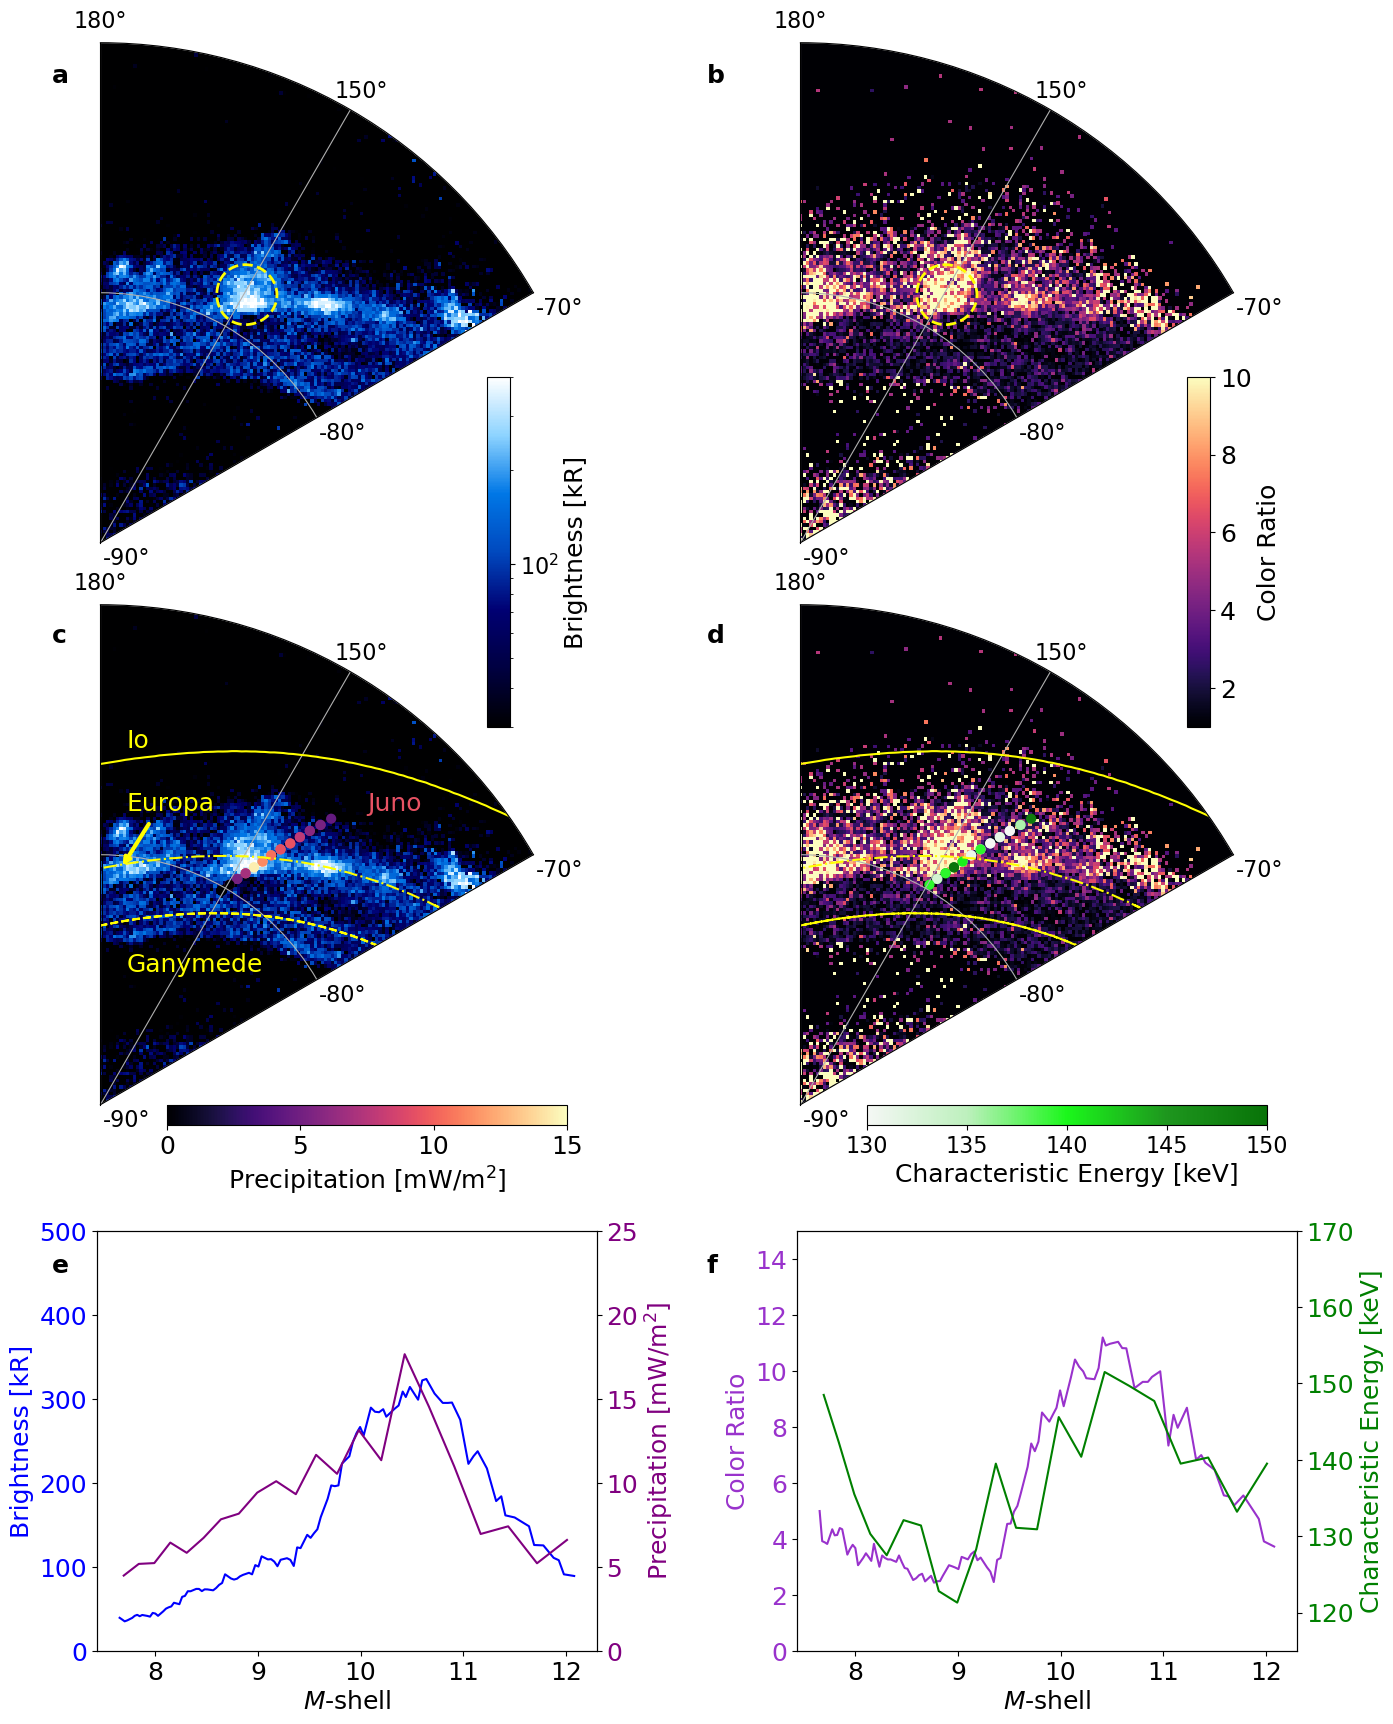

In [14]:
'''This code is used to produce and plot Figure 3'''
import matplotlib.image as mpimg
from scipy.ndimage import map_coordinates
import matplotlib
from pyspedas import time_double

'''Bin data to get estimated brightness and color ratio from aurora data'''
'''Takes the sum of the bin +/-0.5 degrees in Brightness or CR '''

###########################

file_path = '011222_location_low.txt' #location of mapped Juno footprint during low-altitude crossing
data = pd.read_csv(file_path, delim_whitespace=True)

data['Lon_rad'] = np.radians(data['Lon'])
data['Lat']=data['Lat']

# Normalize latitude to range from the center (0) outward (-90° to the center)
data['Lat_norm'] = (data['Lat'] + 90) / 180

longitude_ticks = np.radians([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330])
longitude_labels = ['0°', '', '', '90°', '', '150°', '180°', '', '', '270°', '', '']

lat_ticks = [-80, -70, -60]

lat_ticks_norm = [(lat + 90) / 180 for lat in lat_ticks]

data_all = pd.read_csv('flux_pad_JADE_JEDI_jan_late_hires.txt', delim_whitespace=True)
grouped_data_all = data_all.groupby(['Mshell', 'energy'])['flux'].mean().reset_index()

# Convert 'Time' columns to datetime format
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d/%H:%M:%S')
data_all['Time'] = pd.to_datetime(data_all['Time'], format='%Y-%m-%d/%H:%M:%S')

# Find matching time entries
Time_match = []
for i in np.arange(0, len(Mshell), 1):
    index_mshell = (np.where(data_all['Mshell'] == Mshell[i])[0][0])
    Time_match.append(data_all['Time'][index_mshell])

# Convert Time to numeric for interpolation
data['Time_numeric'] = data['Time'].astype(np.int64) // 10**9  # Convert datetime to seconds
Time_match_numeric = pd.to_datetime(Time_match).astype(np.int64) // 10**9  # Convert datetime to seconds
data['Lon_unwrapped'] = np.unwrap(np.deg2rad(data['Lon'])) * (180 / np.pi)

# interpolate for each column based on the time 
interpolated_R = np.interp(Time_match_numeric, data['Time_numeric'], data['R'])
interpolated_Lat = np.interp(Time_match_numeric, data['Time_numeric'], data['Lat'])
interpolated_Lon_unwrapped = np.interp(Time_match_numeric, data['Time_numeric'], data['Lon_unwrapped'])

# Create a new DataFrame with the interpolated results
data_loc_interpolated = pd.DataFrame({'Time': Time_match,'R': interpolated_R,'Lat': interpolated_Lat,'Lon_unwrapped': interpolated_Lon_unwrapped})
data_loc_interpolated['Lon'] = np.mod(data_loc_interpolated['Lon_unwrapped'], 360) # Re-wrap the interpolated longitude back into the 0-359 degree range
juno_lat = data_loc_interpolated['Lat']
juno_lon = data_loc_interpolated['Lon_unwrapped']

######################### Load the actual aurora data #############################
lat_data = pd.read_csv('Lat_grid.txt', header=None)
lon_data = pd.read_csv('Lon_grid.txt', header=None)
brightness_data = pd.read_csv('Brightness.txt', header=None)
CR_data = pd.read_csv('CR.txt', header=None)

lat_grid = lat_data.values
lon_grid = lon_data.values
brightness = brightness_data.values
brightness = np.where( brightness == 0 , 1e-10, brightness)
CR = CR_data.values
theta = np.deg2rad(lon_grid)  # Convert longitude to radians for polar plotting
r = lat_grid  # Keep latitude as radial distance

# get the longitude and latitude for Juno
#need to consider the interval where the longitude is 360 and latitude needs to be normalized
brightness_along_path = []
CR_along_path = [] 
# Bin width in degrees
bin_width_lon = 0.5
bin_width_lat = 0.5
CR = CR_data.values
CR[CR<0]=0

# Loop through each point in the Juno path
for lat, lon in zip(juno_lat, juno_lon):
    lat_min = lat - bin_width_lat # Latitude binning range
    lat_max = lat + bin_width_lat
    
    lon_min = (lon - bin_width_lon) % 360 # Longitude binning range with wrap-around handling
    lon_max = (lon + bin_width_lon) % 360
    
    lat_mask = (lat_grid >= lat_min) & (lat_grid <= lat_max) # Create masks for lat and lon within the bin range

    if lon_min < lon_max:
        lon_mask = (lon_grid >= lon_min) & (lon_grid <= lon_max) # Normal case where the bin does not cross the 0/360 boundary
    else:
        lon_mask = (lon_grid >= lon_min) | (lon_grid <= lon_max) # Case where the bin crosses the 0/360 boundary
    combined_mask = lat_mask & lon_mask # Combine latitude and longitude masks to find the points within the bin
    
    binned_brightness = brightness[combined_mask] # Extract the brightness values that fall within the bin
    binned_CR = CR[combined_mask]
    if binned_brightness.size > 0: # Calculate the average brightness value in the bin 
        avg_brightness = np.mean(binned_brightness)
        brightness_along_path.append(avg_brightness)
        avg_CR = np.mean(binned_CR)
        CR_along_path.append(avg_CR)        
    else:
        brightness_along_path.append(np.nan) # If no points fall within the bin, append a NaN 
        CR_along_path.append(np.nan)
        
brightness_along_path = np.array(brightness_along_path)
CR_along_path = np.array(CR_along_path)

# Load the Io data
file_path_Io_lat = 'Io_southfoot_lat.txt'
data_io_lat = pd.read_csv(file_path_Io_lat, delim_whitespace=True)
Latitude_io = data_io_lat['Lat']
file_path_Io_lon = 'Io_southfoot_lon.txt'
data_io_lon = pd.read_csv(file_path_Io_lon, delim_whitespace=True)
Longitude_io = data_io_lon['Lon']
# Normalize Io's latitude similarly to the main data
Latitude_io_norm = (Latitude_io + 90) / 180
Longitude_io_rad = np.radians(Longitude_io)

# Load the Europa data
file_path_Eu_lat = 'Eu_southfoot_lat.txt'
data_Eu_lat = pd.read_csv(file_path_Eu_lat, delim_whitespace=True)
Latitude_Eu = data_Eu_lat['Lat']
file_path_Eu_lon = 'Eu_southfoot_lon.txt'
data_Eu_lon = pd.read_csv(file_path_Eu_lon, delim_whitespace=True)
Longitude_Eu = data_Eu_lon['Lon']

# Normalize Io's latitude similarly to the main data
Latitude_Eu_norm = (Latitude_Eu + 90) / 180
Longitude_Eu_rad = np.radians(Longitude_Eu)

# Load the Ganymede data
file_path_Ga_lat = 'Ga_southfoot_lat.txt'
data_Ga_lat = pd.read_csv(file_path_Ga_lat, delim_whitespace=True)
Latitude_Ga = data_Ga_lat['Lat']
file_path_Ga_lon = 'Ga_southfoot_lon.txt'
data_Ga_lon = pd.read_csv(file_path_Ga_lon, delim_whitespace=True)
Longitude_Ga = data_Ga_lon['Lon']

# Normalize Io's latitude similarly to the main data
Latitude_Ga_norm = (Latitude_Ga + 90) / 180
Longitude_Ga_rad = np.radians(Longitude_Ga)

custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom",['#000001','#000041','#000073','#0049bf','#0077e6','#8dd3ff','#ffffff'])
custom_cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("custom",['#f5f7f5','#bdf0bd','#1bf71b','#1e961e','#087308'])

###################################################################################
#### Below are the data results from the integrated precipitation and characteristic energy 
#### from low-resolution electron data, corrected for penetration, derived from IDL code 
Mshell_q = [7.6928,7.8395,7.9907,8.1462,8.3063,8.4705,8.6397,8.8136,8.9932,9.1779,9.3691,9.5662,9.7706,9.9817,10.201,10.429,10.666,10.912,11.169,11.437,11.718,12.010]
Flux_prec_q = [4.473, 5.168, 5.216, 6.436, 5.828, 6.717, 7.822, 8.158, 9.411, 10.090, 9.317, 11.660, 10.530, 13.130, 11.340, 17.650, 14.520, 10.970, 6.949, 7.405, 5.206, 6.594] 
Char_E_q = [148.5,142.3,135.5,130.3,127.5,132.1,131.4,122.8,121.3,128.3,139.5,131.1,130.9,145.6,140.4,151.5,149.7,147.7,139.5,140.3,133.2,139.5]

Q_prec = 'combined_output_precip.txt' #results for precipitation can also be found here
Q_df_prec = pd.read_csv(Q_prec, header=0, sep="\s+", engine='python')
Q_df_prec['Time'] = time_double(Q_df_prec['Time'])  # Convert to numeric time
Q_df_prec['Seconds'] = (Q_df_prec['Time'] - Q_df_prec['Time'].min())

Q_path = 'combined_output_Char_E.txt' #results for characteristic energy can also be found here
Q_df = pd.read_csv(Q_path, header=0, sep="\s+", engine='python')
Q_df['Time'] = time_double(Q_df['Time'])  # Convert to numeric time
Q_df['Seconds'] = (Q_df['Time'] - Q_df['Time'].min())

circle_angles = np.linspace(0, 2 * np.pi, 100) #circle for auroral patch
center_lat =-78.5
center_lon =149.5
lat_radius = 1.2
lon_radius = 6
circle_lon = center_lon + lon_radius * np.cos(circle_angles)
circle_lat = center_lat + lat_radius * np.sin(circle_angles)
circle_theta = np.deg2rad(circle_lon)
circle_r = circle_lat

'''Figure 3 is created below'''
fig = plt.figure(figsize=(10, 14))

# Top left plot [0,0]
ax0 = fig.add_subplot(111, projection='polar', facecolor='none')
c0 = ax0.pcolormesh(theta, r, brightness, cmap=custom_cmap, norm=LogNorm(vmin=30, vmax=400))
ax0.plot(circle_theta, circle_r, color='yellow', linestyle='--', linewidth=2, label='Approximate Circle')
ax0.set_theta_offset(-np.pi / 2.0)
ax0.set_rticks(lat_ticks)
ax0.set_yticks([-90,-80,-70])
ax0.set_yticklabels([f"{tick}°" for tick in ax0.get_yticks()])
ax0.set_rlabel_position(270)
ax0.set_xticks(longitude_ticks)
ax0.set_xticklabels(longitude_labels)
ax0.set_ylim(-90, -70)
ax0.set_yticks([-90,-80,-70])
ax0.set_thetamin(120)
ax0.set_thetamax(180)
cbar0 = fig.colorbar(c0, ax=ax0,shrink=0.5,pad=-0.1,aspect=15,fraction=0.05)
cbar0.set_label('Brightness [kR]',fontsize=18)
ax0.tick_params(axis='x',pad=5,labelsize=16)
ax0.tick_params(axis='y',pad=0,labelsize=16)
cbar0.ax.set_position([0.37, 0.99, 0.3, 0.25])  # [left, bottom, width, height] for the colorbar
cbar0.ax.tick_params(labelsize=16)  # Increase colorbar tick size
ax0.set_position([-0.05, 1.05, 0.5, 0.5])  # [left, bottom, width, height] for the colorbar

# Top right plot [1,0]
ax01 = fig.add_subplot(111, projection='polar', facecolor='none')
c01 = ax01.pcolormesh(theta, r, CR, cmap='magma', vmin=1, vmax=10)
ax01.plot(circle_theta, circle_r, color='yellow', linestyle='--', linewidth=2, label='Approximate Circle')
ax01.set_theta_offset(-np.pi / 2.0)
ax01.set_rticks(lat_ticks)
ax01.set_yticks([-90,-80,-70])
ax01.set_yticklabels([f"{tick}°" for tick in ax01.get_yticks()])
ax01.set_rlabel_position(270)
ax01.set_xticks(longitude_ticks)
ax01.set_xticklabels(longitude_labels)
ax01.set_ylim(-90, -70)
ax01.set_yticks([-90,-80,-70])
ax01.set_thetamin(120)
ax01.set_thetamax(180)
cbar01 = fig.colorbar(c01, ax=ax01, shrink=0.5, aspect=15, pad=0.1, fraction=0.05)
cbar01.set_ticks([2,4,6,8,10])
cbar01.set_ticklabels([2,4,6,8,10])
cbar01.set_label('Color Ratio',fontsize=18)
ax01.tick_params(axis='x',pad=5,labelsize=16)
ax01.tick_params(axis='y',pad=0,labelsize=16)
cbar01.ax.set_position([1.07, 0.99, 0.3, 0.25])  # [left, bottom, width, height] for the colorbar
cbar01.ax.tick_params(labelsize=18)  # Increase colorbar tick size
ax01.set_position([0.65, 1.05, 0.5, 0.5])  # [left, bottom, width, height] for the colorbar

# Mid-left: Aurora data with brightness [0,1]
ax1 = fig.add_subplot(111, projection='polar', facecolor='none')
c1 = ax1.pcolormesh(theta, r, brightness, cmap=custom_cmap, norm=LogNorm(vmin=30, vmax=400))
scatter1 = ax1.scatter(Q_df_prec['Lon'] * np.pi / 180, Q_df_prec['Lat'],
                       c=Q_df_prec['Flux_prec'], marker='o', s=40, vmin=0, vmax=15, cmap='magma')
ax1.set_theta_offset(-np.pi / 2.0)
ax1.plot(Longitude_io_rad, Latitude_io, color='yellow')
ax1.plot(Longitude_Eu_rad, Latitude_Eu, color='yellow',linestyle='dashdot')
ax1.plot(Longitude_Ga_rad, Latitude_Ga, color='yellow',linestyle='--')
ax1.set_rticks(lat_ticks)
ax1.set_yticks([-90,-80,-70])
ax1.set_yticklabels([f"{tick}°" for tick in ax1.get_yticks()])
ax1.set_rlabel_position(270)
ax1.set_xticks(longitude_ticks)
ax1.set_xticklabels(longitude_labels)

ax1.set_ylim(-90, -70)
ax1.set_yticks([-90,-80,-70])
ax1.set_thetamin(120)
ax1.set_thetamax(180)
cbar1 = fig.colorbar(scatter1, ax=ax1, orientation='horizontal', shrink=0.5,pad=-0.02)
cbar1.set_label('Precipitation [mW/m$^2$]',fontsize=18)
ax1.tick_params(axis='x',pad=5,labelsize=16)
ax1.tick_params(axis='y',pad=0,labelsize=16)
cbar1.ax.set_position([0.05, 0.52, 0.4, 0.2])  # [left, bottom, width, height] for the colorbar
ax1.set_position([-0.05, 0.72, 0.5, 0.5])  # [left, bottom, width, height]
cbar1.ax.tick_params(labelsize=18)  # Increase colorbar tick size

# Mid-right: Aurora data with characteristic energy [1,1]
ax2 = fig.add_subplot(111, projection='polar', facecolor='none')
c2 = ax2.pcolormesh(theta, r, CR, cmap='magma', vmin=1, vmax=10)
scatter2 = ax2.scatter(Q_df['Lon'] * np.pi / 180, Q_df['Lat'],
                       c=Q_df['Char_E'], marker='o', s=40, vmin=130, vmax=150, cmap=custom_cmap2)
ax2.set_theta_offset(-np.pi / 2.0)
ax2.plot(Longitude_io_rad, Latitude_io, color='yellow')
ax2.plot(Longitude_Eu_rad, Latitude_Eu, color='yellow',linestyle='dashdot')
ax2.plot(Longitude_Ga_rad, Latitude_Ga, color='yellow',linestyle='--')
ax2.set_rticks(lat_ticks)
ax2.set_rlabel_position(270)
ax2.set_xticks(longitude_ticks)
ax2.set_xticklabels(longitude_labels)
ax2.set_ylim(-90, -70)
ax2.set_yticks([-90,-80,-70])
ax2.set_yticklabels([f"{tick}°" for tick in ax2.get_yticks()])
ax2.tick_params(axis='x',pad=5,labelsize=16)
ax2.tick_params(axis='y',pad=0,labelsize=16)
ax2.set_thetamin(120)
ax2.set_thetamax(180)
cbar2 = fig.colorbar(scatter2, ax=ax2, orientation='horizontal', shrink=0.5,pad=-0.02)
cbar2.set_label('Characteristic Energy [keV]',fontsize=18)
cbar2.ax.set_position([0.75, 0.52, 0.4, 0.2])  # [left, bottom, width, height] for the colorbar
ax2.set_position([0.65, 0.72, 0.5, 0.5])  # [left, bottom, width, height]
cbar2.set_ticks([130,135,140,145,150])
cbar2.ax.tick_params(labelsize=16)  # Increase colorbar tick size

# bottom-left: Line plot for precipitation and brightness
ax4 = fig.add_axes([-0.02, 0.33, 0.5, 0.3])  # [left, bottom, width, height]
ax4.plot(Mshell, brightness_along_path, color='blue', label='Brightness')
ax4.set_ylim(0, 500)
ax4.set_ylabel('Brightness [kR]', color='blue', fontsize=18)
ax4.tick_params(axis='y', labelcolor='blue')
ax4.tick_params(axis='both', which='major', labelsize=18)  # Increase tick sizes
ax4.set_xlabel('$M$-shell', fontsize=18)
ax3 = ax4.twinx()
ax3.plot(Mshell_q, Flux_prec_q, color='purple', label='WA')
ax3.set_xlabel('$M$-shell', fontsize=18)
ax3.set_ylabel('Precipitation [mW/m$^2$]', color='purple', fontsize=18)
ax3.tick_params(axis='y', labelcolor='purple')
ax3.set_ylim(0, 25)
ax3.tick_params(axis='both', which='major', labelsize=18)  # Increase tick sizes

# Bottom-right: Line plot for characteristic energy and color ratio
ax6 = fig.add_axes([0.68, 0.33, 0.5, 0.3])  # [left, bottom, width, height]
ax6.plot(Mshell, CR_along_path, color='darkorchid', label='Color Ratio')
ax6.set_ylim(0, 15)
ax6.set_ylabel('Color Ratio', color='darkorchid', fontsize=18)
ax6.tick_params(axis='y', labelcolor='darkorchid')
ax6.tick_params(axis='both', which='major', labelsize=18)  # Increase tick sizes
ax6.set_xlabel('$M$-shell', fontsize=18)

ax5 = ax6.twinx()

ax5.plot(Mshell_q, Char_E_q, color='green', label='WA')
ax5.set_ylabel('Characteristic Energy [keV]', color='green', fontsize=18)
ax5.tick_params(axis='y', labelcolor='green')
ax5.set_ylim(115, 170)
ax5.tick_params(axis='both', which='major', labelsize=18)  # Increase tick sizes
ax5.set_xlabel('$M$-shell', fontsize=18)

fig.text(-0.065,1.45,'a',fontsize=18,color='black',fontweight='bold')
fig.text(0.59,1.45,'b',fontsize=18,color='black',fontweight='bold')
fig.text(-0.065,1.05,'c',fontsize=18,color='black',fontweight='bold')
fig.text(0.59,1.05,'d',fontsize=18,color='black',fontweight='bold')
fig.text(-0.065,0.6,'e',fontsize=18,color='black',fontweight='bold')
fig.text(0.59,0.6,'f',fontsize=18,color='black',fontweight='bold')

# Adjust layout
fig.text(0.01,0.975,'Io',fontsize=18,color='yellow')
fig.text(0.01,0.93,'Europa',fontsize=18,color='yellow')
fig.text(0.01,0.815,'Ganymede',fontsize=18,color='yellow')

fig.text(0.25,0.93,'Juno',fontsize=18,color='#e75263')
ax1.annotate(
    '', 
    xy=(175*(np.pi/180), -80.5),  
    xytext=(170*(np.pi/180), -78.5), 
    arrowprops=dict(facecolor='yellow', edgecolor='yellow', arrowstyle='->', linewidth=3)
)

plt.show()